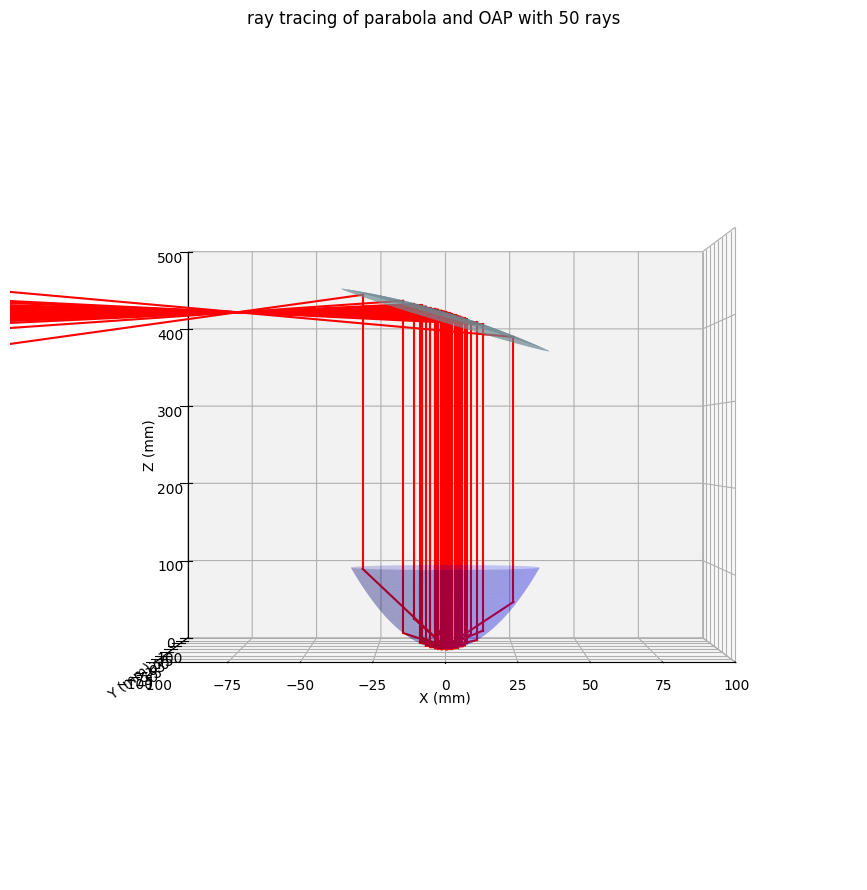

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# === OAP parameters ===
h = -76.2         # x offset
k = 0             # y offset
v = 450           # vertical offset

#focal point of OAP
xfocus2 = h
yfocus2 = k
zfocus2 = v-38.1

## == ion paramerers ==

xfocus = 0
yfocus = 0
zfocus = 3


# Define OAP surface
def oap_3d(x, y):
    return -((x - h)**2 + (y - k)**2) / (2 * 76.2) + v

# Define OAP normal at (x, y)
def oap_3d_normal(x, y):
    dz_dx = (x - h) / 76.2
    dz_dy = (y - k) / 76.2
    normal = np.array([dz_dx, dz_dy, 1])
    return normal / np.linalg.norm(normal)

#2d function of parabola with focal length of 3mm
def parabola(x):
        return x**2/12

# ===  parabola parameters  ===
f = 3.0  # focal length in mm
z_max = parabola(69.282) #max height of parabola in mm
r_max = 69.282 / 2  # max radial extent, width of parabola /2

def paraboloid(r):
    return r**2 / (12)

def surface_normal(x, y):
    r = np.sqrt(x**2 + y**2)
    dzdr = r / (2 * f) if r != 0 else 0
    nx, ny = x * dzdr / r if r != 0 else 0, y * dzdr / r if r != 0 else 0
    normal = np.array([nx, ny, -1])
    return normal / np.linalg.norm(normal)

# === useful functions ===
def reflect_vector(v, n):
    return v - 2 * np.dot(v, n) * n

def generate_fibonacci_directions(n_rays):
    indices = np.arange(0, n_rays, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_rays)
    theta = np.pi * (1 + 5**0.5) * indices

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return np.stack([x, y, z], axis=1)

def find_intersection(ray_origin, ray_dir):
    def equation(t):
        x = ray_origin[0] + t * ray_dir[0]
        y = ray_origin[1] + t * ray_dir[1]
        z = ray_origin[2] + t * ray_dir[2]
        r = np.sqrt(x**2 + y**2)
        return z - paraboloid(r)
    try:
        t_sol = fsolve(equation, 50)[0]
        if t_sol <= 0:
            return None
        x_hit = ray_origin[0] + t_sol * ray_dir[0]
        y_hit = ray_origin[1] + t_sol * ray_dir[1]
        z_hit = ray_origin[2] + t_sol * ray_dir[2]
        r_hit = np.sqrt(x_hit**2 + y_hit**2)
        if 0 <= z_hit <= z_max and r_hit <= r_max:
            return np.array([x_hit, y_hit, z_hit])
        else:
            return None
    except:
        return None

# === main ray simulation ===
def plot(n_rays, x_offset, y_offset, z_offset, xmin, xmax, ymin, ymax, zmin, zmax):
    """
    
    returns 3d plot of parabola and OAP.
    n_rays: number of rays 
    x_offset: offset of ion in the x-direction
    y_offset: offset of ion in the y-direction
    z_offset: offset of ion in the z-direction
    xmin, ymin, zmin: plot boundaries minima
    zmax, ymax, zmax: plot boundaries maxima

    """
    #x_offset, y_offset, z_offset: shift ion by microns from focus
    x_ion = xfocus+x_offset
    y_ion = yfocus+y_offset
    z_ion = zfocus + z_offset

    
    origin = np.array([x_ion, y_ion, z_ion])  # source at paraboloid focus
    directions = generate_fibonacci_directions(n_rays)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot primary paraboloid
    r_vals = np.linspace(0, r_max, 100)
    theta_vals = np.linspace(0, 2*np.pi, 100)
    R, Theta = np.meshgrid(r_vals, theta_vals)
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    Z = paraboloid(R)
    ax.plot_surface(X, Y, Z, alpha=0.2, color='blue', linewidth=0)

    # Plot OAP
    r_oap = np.linspace(38.1 + h, 114.3 + h, 400)
    theta_oap = np.linspace(0, 2 * np.pi, 300)
    R_oap, Theta_oap = np.meshgrid(r_oap, theta_oap)
    X_oap = R_oap * np.cos(Theta_oap)
    Y_oap = R_oap * np.sin(Theta_oap)
    Z_oap = oap_3d(X_oap, Y_oap)
    ax.plot_surface(X_oap, Y_oap, Z_oap, color='lightblue', alpha=0.5, edgecolor='none')

    # focal point of the OAP
    focus_oap = np.array([h, k, v - 38.1])

    zlist=[]

    for d in directions:
        hit = find_intersection(origin, d)
        if hit is None:
            continue

        # plot incident ray from ion to parabola 
        ax.plot([origin[0], hit[0]], [origin[1], hit[1]], [origin[2], hit[2]], 'r')

        # reflect rays off parabola
        n = surface_normal(hit[0], hit[1])
        reflected = reflect_vector(d, n)

        # find points of intersection with OAP
        dx, dy, dz = reflected
        def oap_intersect_eq(t):
            x = hit[0] + dx * t
            y = hit[1] + dy * t
            z = hit[2] + dz * t
            return z - oap_3d(x, y)
        try:

            t_solution = fsolve(oap_intersect_eq, 400)[0]
            x_oap1 = hit[0] + dx * t_solution
            y_oap1 = hit[1] + dy * t_solution
            z_oap1 = hit[2] + dz * t_solution

            #plot rays reflected off the parabola and onto the OAP
            ax.plot([hit[0], x_oap1], [hit[1], y_oap1], [hit[2], z_oap1], 'r')

            #x_oap1, y_oap1, z_oap1 are the points of intersection of the rays with the OAP

            #reflect off the OAP
            n2 = oap_3d_normal(x_oap1, y_oap1)
            #define the vector of rays that hit OAP surface (incident)
            incident_oap = np.array([dx, dy, dz])
            #perform dot product
            reflected2 = reflect_vector(incident_oap, n2)
            
            # Third segment: extend reflected ray
            t3 = 200  # Length to plot after OAP bounce
            x_end = x_oap1 + reflected2[0] * t3
            y_end = y_oap1 + reflected2[1] * t3
            z_end = z_oap1 + reflected2[2] * t3
            
            # Plot third ray segment
            ax.plot([x_oap1, x_end], [y_oap1, y_end], [z_oap1, z_end], 'r')
            #ax.plot([x_oap1, x_end], [z_oap1, z_end], 'g--', zs=0, zdir='y')

            # define the intersection point between the focal plane and the rays
            t = (xfocus2 - x_oap1) / reflected2[0]
            x_int2 = xfocus2
            y_int2 = y_oap1 + reflected2[1] * t
            z_int2 = z_oap1 + reflected2[2] * t
            #list of z-coords where rays intersect image plane
            #zlist.append(np.array([z_int2]))
        
            #make list into numpy array
            result =  np.concatenate([z.flatten() for z in zlist])
            #print(zlist)

            #return result    
            # mark intersection points
            #plt.plot(x_int2, y_int2, z_in2, 'ro')  # Red dot
            #ax.scatter(x_int2, y_int2, z_in2, 'b')  # Red dot
                
    

        except:
            continue
        #return result
    

    # plot OAP's focal point
    #ax.scatter(h, k, v - 38.1, color='black', s=40, label='OAP Focus')
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.set_title(f'ray tracing of parabola and OAP with {n_rays} rays')

    #control viewing angle
    ax.view_init(0, -90, 0)
    plt.tight_layout()
    plt.show()


# Run the simulation
plot(50, 0, 0, 0, -100,100,-100,100,0,500)